In [82]:
%%capture
%run preprocessing.ipynb

In [83]:
# Affiche les variables et modules importés depuis le notebook preprocessing.ipynb
%whos

Variable                          Type                   Data/Info
------------------------------------------------------------------
Adam                              type                   <class 'keras.src.optimizers.adam.Adam'>
EarlyStopping                     type                   <class 'keras.src.callbac<...>_stopping.EarlyStopping'>
EfficientNetB0                    function               <function EfficientNetB0 at 0x0000029749577A60>
ImageDataGenerator                type                   <class 'keras.src.legacy.<...>mage.ImageDataGenerator'>
LEARNING_RATE                     float                  0.001
Model                             type                   <class 'keras.src.models.model.Model'>
ModelCheckpoint                   type                   <class 'keras.src.callbac<...>ckpoint.ModelCheckpoint'>
N_EPOCHS                          int                    10
PCA                               ABCMeta                <class 'sklearn.decomposition._pca.PCA'>
TSNE   

In [84]:
# Autres imports
from tqdm import tqdm
import numpy as np 
import pandas as pd
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, display

import cv2
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.applications.efficientnet import decode_predictions as efficientnet_decode_predictions

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model

# Définit le nombre de coeurs utilisés à 10
os.environ['LOKY_MAX_CPU_COUNT'] = '10'

Le dataframe flipkart a été chargé lors du préprocessing dans les globals, réassignons le au nom flipkart pour plus de clarté.

In [85]:
image_df = globals()['flipkart']
image_df.drop(columns=['product_name', 'description'], inplace=True)
print(image_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   image   1050 non-null   object  
 1   class   1050 non-null   category
dtypes: category(1), object(1)
memory usage: 9.7+ KB
None


**INITIALISE LE MODELE AVEC TOUTES LES LAYERS SANS AUCUN POIDS + CHANGEMENT DE LA COUCHE DE SORTIE A 7 CLASSES**

In [86]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


In [87]:
n_classes = image_df['class'].nunique()

# TRAIN TEST SPLIT

In [88]:
from sklearn.model_selection import train_test_split

In [89]:
X_train, X_test, y_train, y_test = train_test_split(image_df['image'], image_df['class'], test_size=0.2, random_state=314, stratify=image_df['class'])

In [90]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [91]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [102]:
model_params = dict()

**SCENARIO 1 - Entraîner un modèle from scratch avec l'architecture d'EfficientNet**

In [103]:
# Définit le scénario
scenario='1'

# Enregistre les paramètres du modèle
model_params[scenario] = {
    'include_top': True,
    'weights': None,
    'input_shape': (224, 224, 3),
    'classes': n_classes,
    'classifier_activation': 'softmax'
}

# Charge le modèle EfficientNetB0
model = EfficientNetB0(**model_params[scenario])

# Rends les couches entraînables
model.trainable=True

In [104]:
# Affiche les couches de sortie du modèle
model.layers[-3:]

[<GlobalAveragePooling2D name=avg_pool, built=True>,
 <Dropout name=top_dropout, built=True>,
 <Dense name=predictions, built=True>]

In [94]:
def create_test_generator(data, image_size=(224, 224), batch_size=32):

    datagen = ImageDataGenerator(
        preprocessing_function=efficientnet_preprocess_input
    )
    test_generator = datagen.flow_from_dataframe(
        data,
        directory='images/',
        x_col='image',
        y_col='class',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    return test_generator

In [95]:
def compile_and_fit(model, N_EPOCHS, LEARNING_RATE, scenario, data_augmentation_params=None):
    if data_augmentation_params is not None:
        datagen = ImageDataGenerator(
            preprocessing_function=efficientnet_preprocess_input,
            validation_split=0.2,
            **data_augmentation_params
        )
    else:
        datagen = ImageDataGenerator(
        preprocessing_function=efficientnet_preprocess_input,
        validation_split=0.2
        )

    train_generator = datagen.flow_from_dataframe(
        dataframe=train,
        directory='images',
        x_col='image',
        y_col='class',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = datagen.flow_from_dataframe(
        dataframe=train,
        directory='images',
        x_col='image',
        y_col='class',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )

    # Compile le modèle
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Définir le callback pour sauvegarder les poids du modèle
    checkpoint = ModelCheckpoint(
        scenario+'_model_{epoch:02d}.weights.h5',
        save_weights_only=True,
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1)

    # Entraîne le modèle
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=N_EPOCHS,
        callbacks=[checkpoint]
    )

    # Retourne l'historique de l'entraînement
    return history

Found 672 validated image filenames belonging to 7 classes.


Found 168 validated image filenames belonging to 7 classes.
Epoch 1/10


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1458 - loss: 9.8829 

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_accuracy improved from -inf to 0.11905, saving model to 1_model_01.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step - accuracy: 0.1461 - loss: 9.7417 - val_accuracy: 0.1190 - val_loss: 33394.4570
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1287 - loss: 2.6666
Epoch 2: val_accuracy improved from 0.11905 to 0.14881, saving model to 1_model_02.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 101s 5s/step - accuracy: 0.1296 - loss: 2.6659 - val_accuracy: 0.1488 - val_loss: 173.5048
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1358 - loss: 2.5102
Epoch 3: val_accuracy did not improve from 0.14881
21/21 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step - accuracy: 0.1353 - loss: 2.5131 - val_accuracy: 0.1190 - val_loss: 2.0058
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1494 - loss: 2.1971
Epoch 4: val_accuracy improved from 0.14881 to 0.16071, saving model to 1_model_04.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 101s 5s/step - accuracy: 0.1497 - loss:

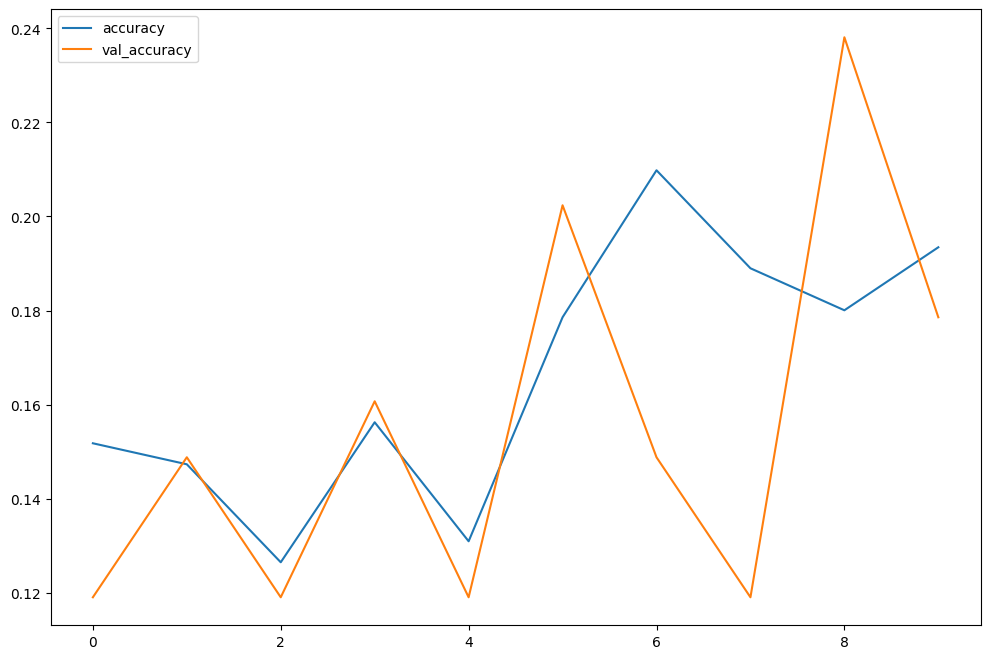

In [96]:
LEARNING_RATE = 1e-2
N_EPOCHS = 10

history = compile_and_fit(model, N_EPOCHS, LEARNING_RATE, scenario=scenario)

# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [97]:
test_generator = create_test_generator(test)

Found 210 validated image filenames belonging to 7 classes.


In [98]:
# Définit le nom du modèle à charger
model_name = 'model_04.weights.h5'

# Charger les poids du modèle sauvegardés
model.load_weights(model_name)

# Évaluer le modèle avec les poids chargés
score = model.evaluate(test_generator)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 428 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 907ms/step - accuracy: 0.6953 - loss: 1.0637
Test loss: 1.0042484998703003
Test accuracy: 0.7523809671401978


Bien que le modème améliore sensiblement ses performances sur le d'entraînement, il ne parvient pas à généraliser sur le jeu de validation.<br>
Cela nécessiterait davantage d'epochs et de temps pour entraîner le modèle.<br>
Toutefois, vu le nombre limité d'images que le modèle voit lors de son entraînement, on constate que les performance sur le jeu de validation ne s'améliorent pas significativement.

**SCENARIO 2 - Entraîner un modèle avec Transfer Learning en utilisant les poids d'EfficientNetB0 entraîné sur imagenet**

In [105]:
# SCENARIO 2A : On utilise les poids pré-entraînés sur ImageNet ET on reproduit les dernières couches de l'output du modèle
scenario = '2a'

# Enregistre les paramètres du modèle
model_params[scenario] = {
    'include_top': False,
    'weights': 'imagenet',
    'input_shape': (224, 224, 3)
}

# Charge le modèle EfficientNetB0
model = EfficientNetB0(**model_params[scenario])

# Gèle toutes les couches du modèle
model.trainable = False

# Affiche les couches du modèle d'entrée et de sortie
print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2, name='top_dropout')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax', name='predictions')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)


Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_4343>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_4580>


In [100]:
LEARNING_RATE = 1e-3
N_EPOCHS = 10

history = compile_and_fit(model, N_EPOCHS, LEARNING_RATE, scenario=scenario)

# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

Found 672 validated image filenames belonging to 7 classes.
Found 168 validated image filenames belonging to 7 classes.
Epoch 1/10


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 963ms/step - accuracy: 0.3501 - loss: 1.9315

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_accuracy improved from -inf to 0.79762, saving model to 2a_model_01.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.3565 - loss: 1.9127 - val_accuracy: 0.7976 - val_loss: 0.9741
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - accuracy: 0.7552 - loss: 0.6853
Epoch 2: val_accuracy improved from 0.79762 to 0.84524, saving model to 2a_model_02.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7568 - loss: 0.6824 - val_accuracy: 0.8452 - val_loss: 0.7158
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.8461 - loss: 0.5019
Epoch 3: val_accuracy improved from 0.84524 to 0.85119, saving model to 2a_model_03.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8468 - loss: 0.5005 - val_accuracy: 0.8512 - val_loss: 0.6275
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - accuracy: 0.8906 - loss: 0.3776
Epoch 4: val_accuracy improved from 0.85119 to 0.86310, saving model to 2a_model_04.weights.h5
21/21 ━━━━━━━━━━━━━

KeyboardInterrupt: 

In [73]:
# Définit le nom du modèle à charger
model_name = 'model_08.weights.h5'

# Charger les poids du modèle sauvegardés
model.load_weights(model_name)

# Évaluer le modèle avec les poids chargés
score = model.evaluate(test_generator)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 950ms/step - accuracy: 0.7429 - loss: 0.7911
Test loss: 0.6698338389396667
Test accuracy: 0.800000011920929


In [75]:
# SCENARIO 2B : On utilise les poids pré-entraînés sur ImageNet ET avec une sortie sans régularisation avec deux dense hidden layer.
scenario = '2b'
# Enregistre les paramètres du modèle
model_params[scenario] = {
    'include_top': False,
    'weights': 'imagenet',
    'input_shape': (224, 224, 3)
}

# Charge le modèle EfficientNetB0
model = EfficientNetB0(**model_params[scenario])

# Gèle toutes les couches du modèle
model.trainable = False

# Affiche les couches du modèle d'entrée et de sortie
print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax', name='predictions')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)

Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_3138>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_3375>


Found 672 validated image filenames belonging to 7 classes.
Found 168 validated image filenames belonging to 7 classes.
Epoch 1/10


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1000ms/step - accuracy: 0.9274 - loss: 0.2297

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_accuracy improved from -inf to 0.86310, saving model to model_acc0.863095_loss0.435847_e01.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9270 - loss: 0.2310 - val_accuracy: 0.8631 - val_loss: 0.4358
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - accuracy: 0.9815 - loss: 0.0621
Epoch 2: val_accuracy did not improve from 0.86310
21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9814 - loss: 0.0621 - val_accuracy: 0.8512 - val_loss: 0.5019
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - accuracy: 1.0000 - loss: 0.0172
Epoch 3: val_accuracy improved from 0.86310 to 0.87500, saving model to model_acc0.875000_loss0.487776_e03.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 1.0000 - loss: 0.0172 - val_accuracy: 0.8750 - val_loss: 0.4878
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 957ms/step - accuracy: 0.9988 - loss: 0.0095
Epoch 4: val_accuracy did not improve from 0.87500
21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9988 - l

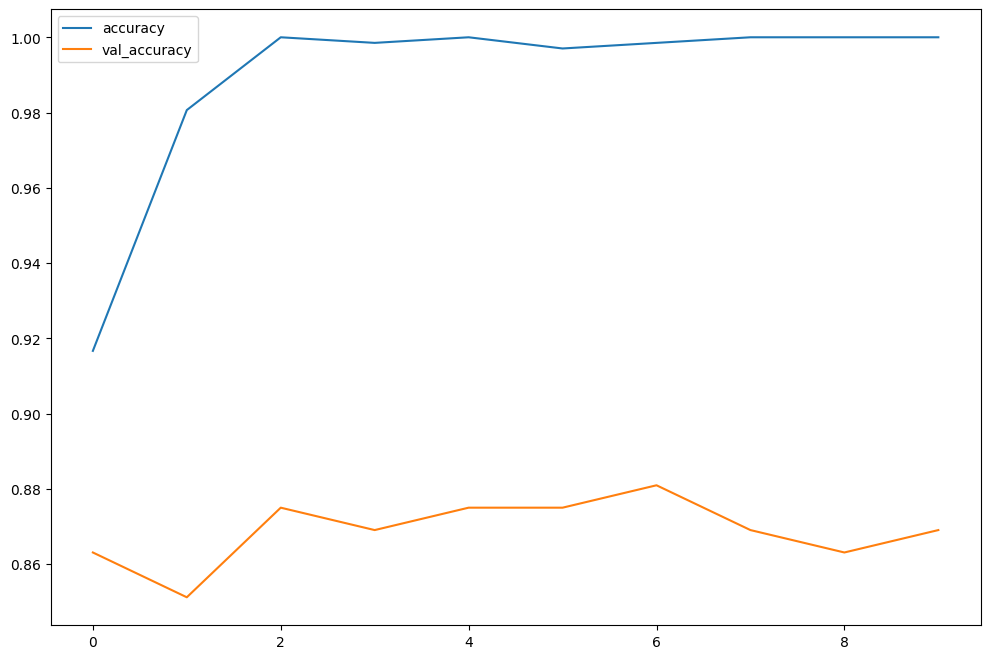

In [78]:
LEARNING_RATE = 1e-3
N_EPOCHS = 10

history = compile_and_fit(model, N_EPOCHS, LEARNING_RATE, scenario=scenario)

# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [80]:
# SCENARIO 2c : On utilise les poids pré-entraînés sur ImageNet ET avec une sortie sans régularisation avec deux dense hidden layer.
scenario = "2C"
# Enregistre les paramètres du modèle
model_params[scenario] = {
    'include_top': False,
    'weights': 'imagenet',
    'input_shape': (224, 224, 3)
}

# Charge le modèle EfficientNetB0
model = EfficientNetB0(**model_params[scenario])

# Gèle toutes les couches du modèle
model.trainable = False

# Affiche les couches du modèle d'entrée et de sortie
print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax', name='predictions')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)

Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_3379>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_3616>


Found 672 validated image filenames belonging to 7 classes.
Found 168 validated image filenames belonging to 7 classes.
Epoch 1/10


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6307 - loss: 1.1639

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_accuracy improved from -inf to 0.86905, saving model to 2Bmodel_01.weights.h5
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6359 - loss: 1.1481 - val_accuracy: 0.8690 - val_loss: 0.4486
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9303 - loss: 0.2158
Epoch 2: val_accuracy did not improve from 0.86905
21/21 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9309 - loss: 0.2139 - val_accuracy: 0.8690 - val_loss: 0.4596
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9976 - loss: 0.0333
Epoch 3: val_accuracy did not improve from 0.86905
21/21 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9973 - loss: 0.0333 - val_accuracy: 0.8631 - val_loss: 0.4934
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0150
Epoch 4: val_accuracy did not improve from 0.86905
21/21 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 1.0000 - loss: 0.0148 - val_accuracy: 0.8631 - val_loss: 0.5608
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/st

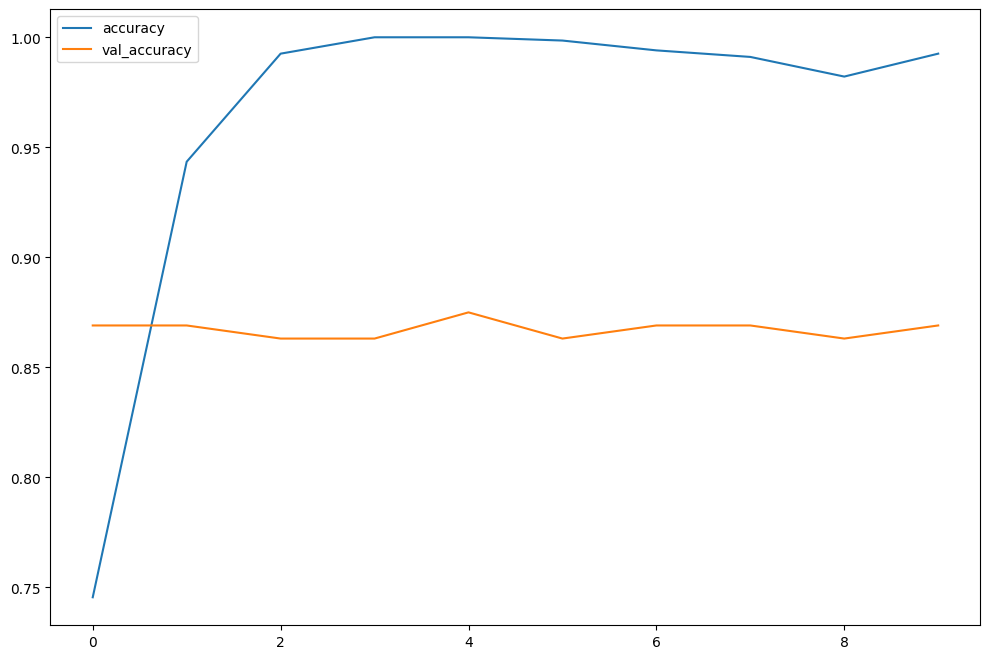

In [81]:
LEARNING_RATE = 1e-3
N_EPOCHS = 10

history = compile_and_fit(model, N_EPOCHS, LEARNING_RATE, scenario=scenario)

# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

# SCENARIO 3 - Entraîner le modèle 

In [21]:
# SCENARIO 3 : Même modèle que le SCENARIO 2 mais on dégèle les dernières couches du modèle
scenario = '3'
# Enregistre les paramètres du modèle
model_params[scenario] = {
    'include_top': False,
    'weights': 'imagenet',
    'input_shape': (224, 224, 3)
}

# Charge le modèle EfficientNetB0
model = EfficientNetB0(**model_params[scenario])


# Unfreeze les 10 dernières couches du modèle exceptés les couches BatchNormalization
for layer in model.layers[-6:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Affiche les couches du modèle d'entrée et de sortie
print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2, name='top_dropout')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax', name='predictions')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)


Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_724>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_961>


Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Epoch 1/20


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/27 ━━━━━━━━━━━━━━━━━━━━ 1:16 4s/step - accuracy: 0.1796 - loss: 2.7805

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 196s 5s/step - accuracy: 0.2518 - loss: 2.4322 - val_accuracy: 0.4333 - val_loss: 1.5363
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 133s 5s/step - accuracy: 0.6628 - loss: 0.9977 - val_accuracy: 0.5952 - val_loss: 1.3102
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.8189 - loss: 0.5819 - val_accuracy: 0.6048 - val_loss: 1.1954
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step - accuracy: 0.9030 - loss: 0.3352 - val_accuracy: 0.6476 - val_loss: 1.1053
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step - accuracy: 0.9154 - loss: 0.2693 - val_accuracy: 0.6714 - val_loss: 1.0490
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 135s 5s/step - accuracy: 0.9262 - loss: 0.2420 - val_accuracy: 0.6905 - val_loss: 1.0030
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 133s 5s/step - accuracy: 0.9541 - loss: 0.1899 - val_accuracy: 0.6905 - val_loss: 0.9562
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.9695 - loss: 0.1245 - val_accuracy: 0.7048 - val_loss: 0.

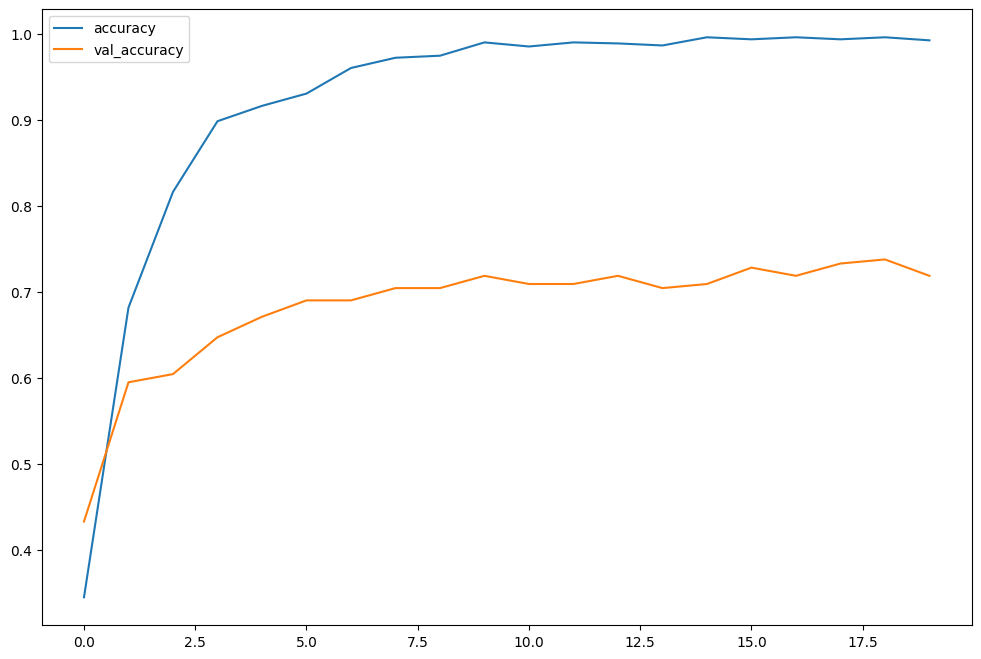

In [22]:
LEARNING_RATE = 1e-3
N_EPOCHS = 15

history = compile_and_fit(model, N_EPOCHS, LEARNING_RATE, scenario=scenario)

# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [23]:
# SCÉNARIO 4 : On utilise le même modèle que le SCENARIO 3 mais on rajoute de la data augmentation
scenario = '4'
# Enregistre les paramètres du modèle
model_params[scenario] = {
    'include_top': False,
    'weights': 'imagenet',
    'input_shape': (224, 224, 3)
}

# Charge le modèle EfficientNetB0
model = EfficientNetB0(**model_params[scenario])


# Unfreeze les 10 dernières couches du modèle exceptés les couches BatchNormalization
for layer in model.layers[-6:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Affiche les couches du modèle d'entrée et de sortie
print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2, name='top_dropout')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax', name='predictions')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)

Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_966>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_1203>


Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1/20


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step - accuracy: 0.1983 - loss: 2.5630 - val_accuracy: 0.3857 - val_loss: 1.6526
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 156s 6s/step - accuracy: 0.6268 - loss: 1.0760 - val_accuracy: 0.5000 - val_loss: 1.4359
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 148s 5s/step - accuracy: 0.7062 - loss: 0.8688 - val_accuracy: 0.6143 - val_loss: 1.2484
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 150s 5s/step - accuracy: 0.7699 - loss: 0.6775 - val_accuracy: 0.6619 - val_loss: 1.0858
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 148s 5s/step - accuracy: 0.8229 - loss: 0.5492 - val_accuracy: 0.6619 - val_loss: 1.0201
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.8624 - loss: 0.3969 - val_accuracy: 0.7333 - val_loss: 0.9558
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - accuracy: 0.8866 - loss: 0.3499 - val_accuracy: 0.7000 - val_loss: 0.9166
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.8874 - loss: 0.3175 - val_accuracy: 0.7381 - val_loss: 0.

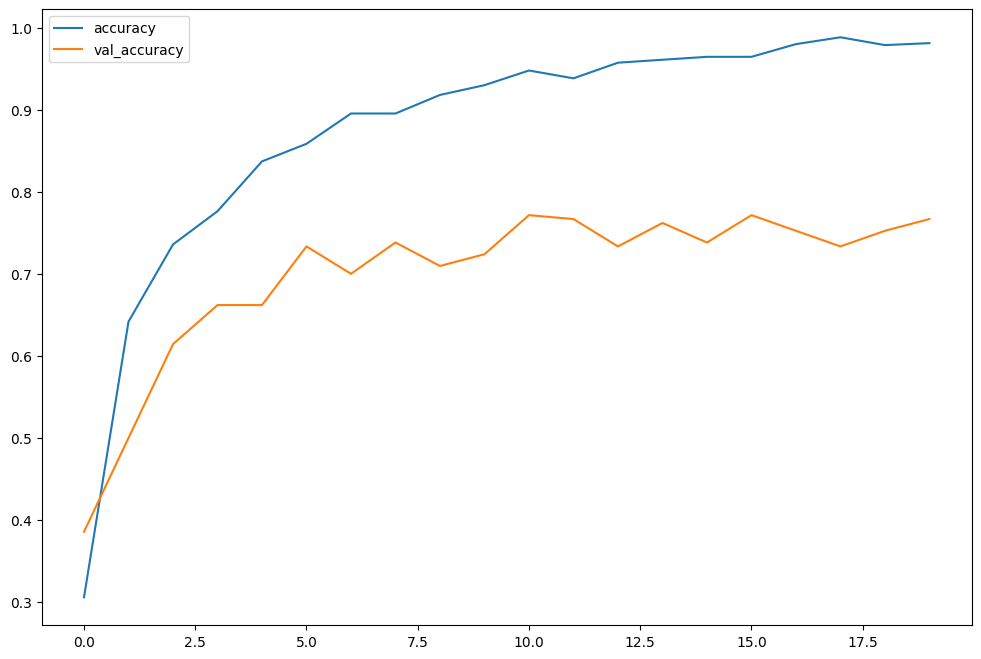

In [25]:
N_EPOCHS = 20
LEARNING_RATE = 1e-4
data_augmentation_params = {
    'width_shift_range': 0.15,
    'height_shift_range': 0.15,
    'shear_range': 0.15,
    'zoom_range': 0.15,
    'horizontal_flip': True,
    'vertical_flip': True
}

history = compile_and_fit(model, N_EPOCHS, LEARNING_RATE, scenario=scenario, data_augmentation_params=data_augmentation_params)

# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [26]:
# SCÉNARIO 5 : On utilise le même modèle que dans le scénario 2 avec la data augmentation et plus d'EPOCH 
model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Gèle toutes les couches du modèle
model.trainable = False

# Affiche les couches du modèle d'entrée et de sortie
print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2, name='top_dropout')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax', name='predictions')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)

Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_1208>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_1445>


Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Epoch 1/15


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 9/27 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2264 - loss: 2.2212

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.3790 - loss: 1.8084 - val_accuracy: 0.5714 - val_loss: 1.3245
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7236 - loss: 0.8898 - val_accuracy: 0.6810 - val_loss: 1.1230
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7964 - loss: 0.6911 - val_accuracy: 0.6810 - val_loss: 1.0248
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8391 - loss: 0.4786 - val_accuracy: 0.6714 - val_loss: 0.9960
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8412 - loss: 0.4209 - val_accuracy: 0.7190 - val_loss: 0.8820
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8529 - loss: 0.4287 - val_accuracy: 0.6619 - val_loss: 0.9361
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8854 - loss: 0.3434 - val_accuracy: 0.7333 - val_loss: 0.8221
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8745 - loss: 0.3458 - val_accuracy: 0.7429 - val_loss: 0.8196
Epo

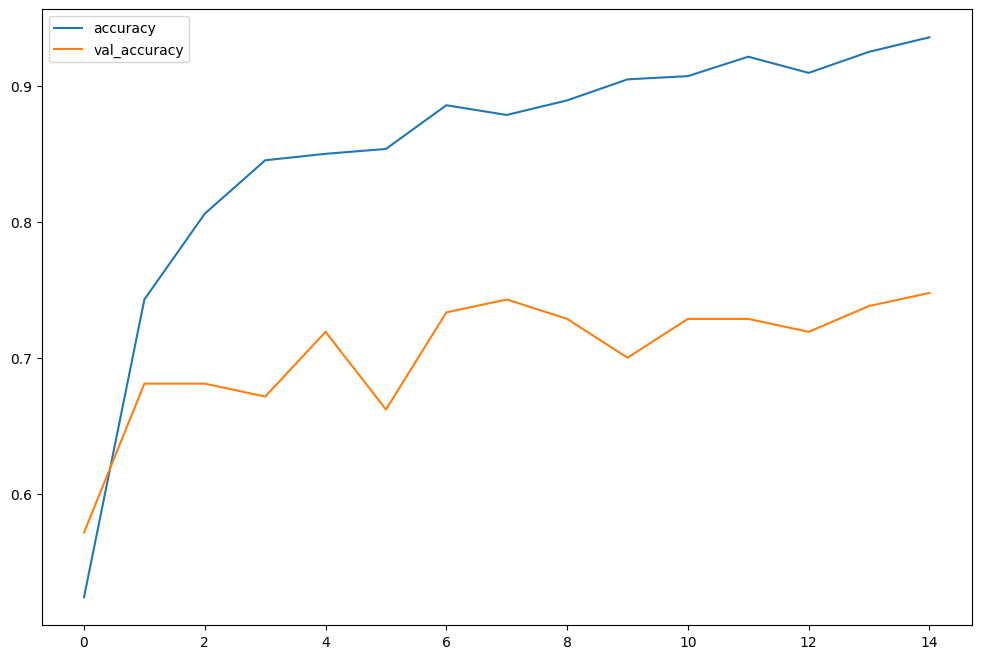

In [27]:
N_EPOCHS = 15
LEARNING_RATE = 1e-3
data_augmentation_params = {
    'width_shift_range': 0.15,
    'height_shift_range': 0.15,
    'shear_range': 0.15,
    'zoom_range': 0.15,
    'horizontal_flip': True,
    'vertical_flip': True
}

history = compile_and_fit(model, N_EPOCHS, LEARNING_RATE, data_augmentation_params)

# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [28]:
# SCENARIO 6 : On utilise les poids pré-entraînés sur ImageNet avec des couches de sortie différentes
model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    classes=7,
    classifier_activation='softmax'
)

print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)

# Gèle les poids des couches de convolution
for layer in model.layers[:-6]:
    layer.trainable = False

# Compile le modèle
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_1450>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_1687>


Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Epoch 1/15


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 8/27 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3585 - loss: 1.8109

c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.5463 - loss: 1.5915 - val_accuracy: 0.4619 - val_loss: 1.3437
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8512 - loss: 0.6843 - val_accuracy: 0.7810 - val_loss: 0.8415
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8822 - loss: 0.4280 - val_accuracy: 0.8048 - val_loss: 0.7436
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9251 - loss: 0.2945 - val_accuracy: 0.8095 - val_loss: 0.6715
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9557 - loss: 0.2209 - val_accuracy: 0.8476 - val_loss: 0.6025
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9684 - loss: 0.1442 - val_accuracy: 0.8238 - val_loss: 0.6172
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9745 - loss: 0.1372 - val_accuracy: 0.8476 - val_loss: 0.5743
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9802 - loss: 0.0994 - val_accuracy: 0.8286 - val_loss: 0.5967
Epo

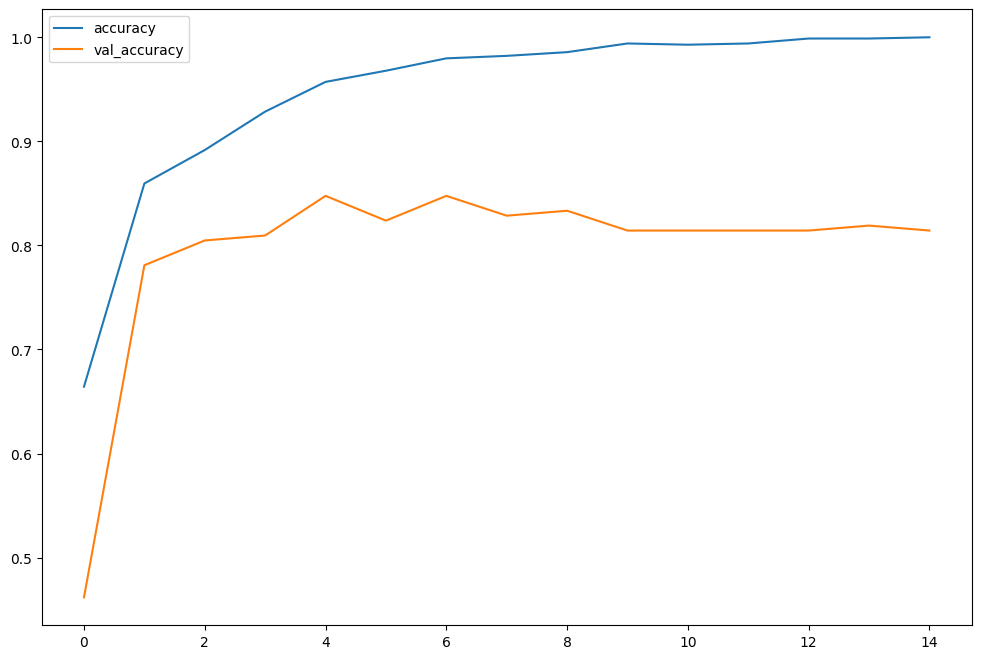

In [29]:
datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess_input,
    validation_split=0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    directory='images',
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    directory='images',
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Entraîne le modèle
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15
)

# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [30]:
# SCENARIO 6 : On utilise les poids pré-entraînés sur ImageNet avec une couche dense supplémentaire et plus d'netraînement de couches
model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    classes=7,
    classifier_activation='softmax'
)

print("Input: ", model.input)
print("Output: ", model.output)

# Ajoute les dernières couches denses du modèle
x = model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)

# Gèle les poids des couches de convolution
for layer in model.layers[:-6]:
    layer.trainable = False

# Compile le modèle
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Input:  <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor_1692>
Output:  <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, name=keras_tensor_1929>


Found 840 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Epoch 1/15


c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\BS6517\Documents_local\projet_6\oc_projet_6\.venv\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.5854 - loss: 1.1808 - val_accuracy: 0.7571 - val_loss: 0.7962
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 4740s 3s/step - accuracy: 0.8652 - loss: 0.3951 - val_accuracy: 0.7714 - val_loss: 0.7020
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.9414 - loss: 0.2017 - val_accuracy: 0.7000 - val_loss: 1.2384
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9408 - loss: 0.1854 - val_accuracy: 0.7286 - val_loss: 0.9842
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.9617 - loss: 0.1333 - val_accuracy: 0.7476 - val_loss: 0.9665
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9748 - loss: 0.0941 - val_accuracy: 0.7619 - val_loss: 0.8983
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.9728 - loss: 0.0890 - val_accuracy: 0.7429 - val_loss: 1.1200
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.9889 - loss: 0.0490 - val_accuracy: 0.7238 - val_loss: 1.2300
E

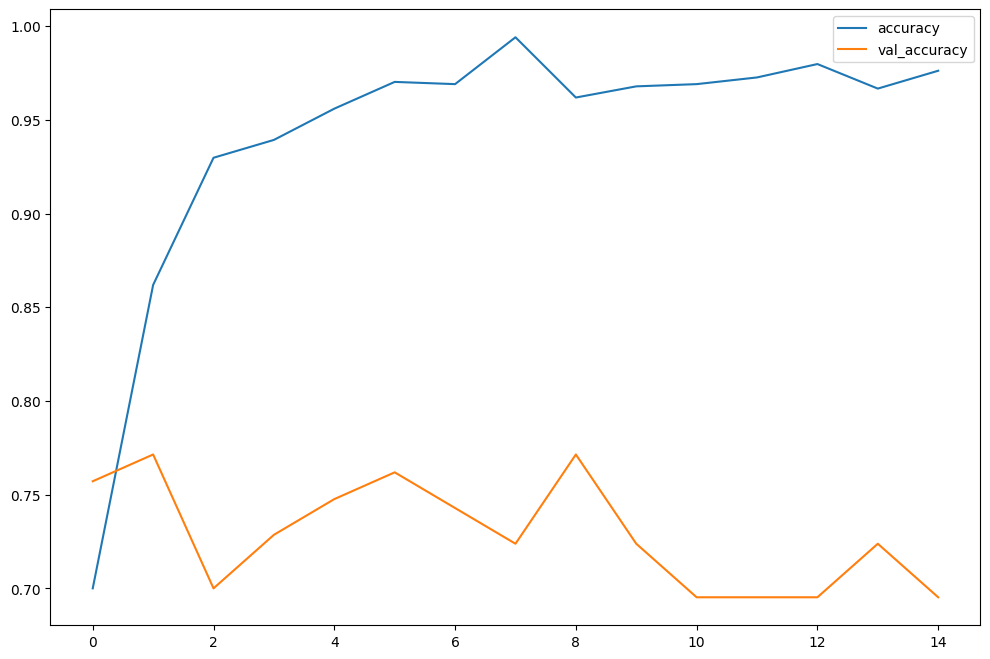

In [31]:
# Crée un datagen avec des paramètres d'optimisation différents
datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess_input,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.25,
    shear_range=0.25,
)

train_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    directory='images',
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=image_df,
    directory='images',
    x_col='image',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Entraîne le modèle
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15
)

# Affiche les courbes d'apprentissage
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()